In [1]:
import pandas as pd
from urllib.parse import urlparse, unquote
import re
from collections import Counter
from bs4 import BeautifulSoup
from requests import Response
from sklearn.model_selection import train_test_split

# Preprocessing

## Load Dataset

In [2]:
data = pd.read_csv('data/PhiUSII.csv')

In [3]:
data.describe()

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
count,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,...,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000
mean,34.573095,21.470396,0.002706,78.430778,0.845508,0.260423,0.055747,2.764456,1.164758,0.002057,...,0.237007,0.023474,0.486775,26.075689,6.333111,10.522305,65.071113,2.377629,49.262516,0.571895
std,41.314153,9.150793,0.051946,28.976055,0.216632,0.251628,0.010587,0.599739,0.600969,0.045306,...,0.425247,0.151403,0.499826,79.411815,74.866296,22.312192,176.687539,17.641097,161.027430,0.494805
min,13.000000,4.000000,0.000000,0.155574,0.000000,0.000000,0.001083,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,16.000000,0.000000,57.024793,0.680000,0.005977,0.050747,2.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,27.000000,20.000000,0.000000,100.000000,1.000000,0.079963,0.057970,3.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,8.000000,2.000000,6.000000,12.000000,0.000000,10.000000,1.000000
75%,34.000000,24.000000,0.000000,100.000000,1.000000,0.522907,0.062875,3.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,29.000000,8.000000,15.000000,88.000000,1.000000,57.000000,1.000000
max,6097.000000,110.000000,1.000000,100.000000,1.000000,0.522907,0.090824,13.000000,10.000000,1.000000,...,1.000000,1.000000,1.000000,8956.000000,35820.000000,6957.000000,27397.000000,4887.000000,27516.000000,1.000000


# Load top 10mil sites

In [4]:
top10mil = pd.read_csv('data/top10milliondomains.csv')
top10mil.head()

,Rank,Domain,Open Page Rank
0,1,facebook.com,10.0
1,2,fonts.googleapis.com,10.0
2,3,google.com,10.0
3,4,youtube.com,10.0
4,5,twitter.com,10.0


In [5]:
def get_tld(domain: str) -> str:
  return domain.split('.')[-1]

top10mil['TLD'] = top10mil['Domain'].apply(get_tld)

In [6]:
tld = top10mil.groupby('TLD', as_index=False).agg(Count=('Rank', 'count')).sort_values('Count', ascending=False).reset_index()
tld['Ratio'] = tld['Count'] / 10000000
tld[['TLD', 'Ratio']].to_csv('data/tld.csv')

In [7]:
# chars = list("abcdefghijklmnopqrstuvwxyz0123456789")
# frequency = Counter(top10mil['Domain'].str.cat())
# total = sum(frequency.values())
# frequency_distribution = pd.DataFrame({ letter: count / total for letter, count in frequency.most_common()}, index=['Frequency']).transpose()
frequency_distribution = pd.read_csv("data/frequency.csv")

In [14]:
# frequency_distribution.to_csv('data/frequency.csv')

# Feature Extraction

## URL

### URL Length

In [5]:
def url_length(url: str) -> int:
  return len(url) - 1

url = data['URL'].head(1)[0]
url_length(url) == int(data['URLLength'].head(1)[0])

True

In [31]:
def get_domain(url: str) -> str:
  return urlparse(url).netloc

url = data['URL'].head(1)[0]
get_domain(url) == data['Domain'].head(1)[0]

True

In [7]:
def get_domain_length(domain: str) -> int:
  return len(domain)

url = data['Domain'].head(1)[0]
get_domain_length(url) == int(data['DomainLength'].head(1)[0])

True

In [8]:
def is_domain_ip(domain: str) -> bool:
  return not domain.split('.')[-1].isalpha()

url = data['Domain'].head(1)[0]
is_domain_ip(url) == int(data['IsDomainIP'].head(1)[0])

True

In [9]:
def get_tld(domain: str) -> str:
  return domain.split('.')[-1]

url = data['Domain'].head(1)[0]
get_tld(url) == data['TLD'].head(1)[0]

True

# URL Similarity Index

In [59]:
def get_url_similarity_index(src: str, tar: str) -> int:
  # X = shortest url, Y = longest url, n = length of shorttest from src to tar
  X, Y, n = get_min(src, tar)
  length_of_longest_url = max(len(src), len(tar))
  similarity_index = 0
  base_value = 50 / length_of_longest_url
  sum_of_natural_numbers = (length_of_longest_url * (length_of_longest_url + 1)) / 2
  for i in range(0, n):
    if X[i] == Y[i]:
      similarity_index = similarity_index + base_value + (50 * (length_of_longest_url - i)) / sum_of_natural_numbers
      if similarity_index == 100:
                return similarity_index
    else:
      # remove ith (unmatched) character from longest url
      Y = Y[:i] + Y[i + 1:]
      # Set X = shortest, Y = longest, and n = length of shortest url
      X, Y, n = get_min(src, tar)
      i = i - 1
  return similarity_index

def get_min(src: str, tar: str) -> tuple[str, str, int]:
  return min([src, tar], key=len), max([src, tar], key=len), min(len(src), len(tar))

float(top10mil['Domain'].head(1_000_000).apply(lambda row: get_url_similarity_index("google.com", row)).max())

100.0

In [35]:
# 1. remove the tld
# 2. get longest sequence of alphabet
# 3. get longest sequence of special chars
# 4. get longest sequence of numbers
# 5. devide by length
def char_continuation_rate(domain: str) -> float:
  domain_check = ".".join(domain.split('.')[:len(domain.split('.')) - 1])
  abc_check = r"[^0-9|\!\@\#\$\%\^\&\*\(\)\{\}\|\\\+\-\=\_\\\/\.\,]+"
  number_check = r"[0-9]+"
  special_check = r"[\!\@\#\$\%\^\&\*\(\)\{\}\|\\\+\-\=\_\\\/\.\,]+"
  abc_regex = re.compile(abc_check)
  number_regex = re.compile(number_check)
  special_regex = re.compile(special_check)
  max_abc = max(abc_regex.findall(domain_check), key=len)
  max_number = max(number_regex.findall(domain_check), key=len)
  max_special = max(special_regex.findall(domain_check), key=len)
  return (len(max_abc) + len(max_number) + len(max_special)) / len(domain_check)

In [80]:
def get_tld_legitimate_prob(domain):
  tld_result = get_tld(domain)
  try:
    return float(tld[tld['TLD'] == tld_result]['Ratio'].values[0])
  except Exception as _:
    return 0

In [24]:
def get_url_char_frequency(domain: str) -> float:
  freq = 0
  for letter in domain:
    freq += float(frequency_distribution[frequency_distribution['Letter'] == letter]['Frequency'].values[0] / len(domain))
  return freq

0.05234702383592421

In [25]:
def get_tld_length(domain):
  return len(get_tld(domain))

In [33]:
def get_num_of_sub_domains(domain):
  return len(domain.split(".")) - 2

2

In [ ]:
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

def num_of_obsufcation(url):
  return levenshteinDistance(unquote(url), url) / 3

In [ ]:
def has_obfuscation(url):
  return num_of_obsufcation(url) > 0

In [55]:
def is_https(url):
  return urlparse(url).scheme == 'https'

False

In [71]:
def num_of_letters(url):
  return len("".join(re.findall(r"[^0-9|\!\@\#\$\%\^\&\*\(\)\{\}\|\\\+\-\=\_\\\/\.\,]+", url)))

In [58]:
def num_of_digits(url):
  return len("".join(re.findall(r'\d+', url)))

In [59]:
def num_of_equal(url):
  return len("".join(re.findall(r'=+', url)))

In [60]:
def num_of_qmark(url):
  return len("".join(re.findall(r'\?+', url)))

In [61]:
def num_of_amp(url):
  return len("".join(re.findall(r'\&+', url)))

## HTML Features

In [64]:
def longest_line_of_code(html):
  return len(max(html.split('\n'), key=len))

In [65]:
def has_favicon(html):
  soup = BeautifulSoup(html)
  icon = soup.find("link", rel="shortcut icon")
  if not icon:
    return 0
  return 1

In [ ]:
def has_title(html):
  soup = BeautifulSoup(html)
  title = soup.find("title")
  if not title:
    return 0
  return 1

In [ ]:
def get_title(html):
  soup = BeautifulSoup(html)
  title = soup.find("title")
  if not title:
    return ""
  return title.string

In [67]:
def number_of_redirects(response):
  return len(response.history)

In [68]:
def num_of_iframe(html):
  soup = BeautifulSoup(html)
  iframe = soup.find_all("iframe")
  return len(iframe)

In [69]:
def has_hidden_fields(html):
  soup = BeautifulSoup(html)
  hidden_tags = soup.find_all("input", type="hidden")
  if not hidden_tags:
    return 0
  return 1

In [70]:
def get_title_url_match_score(url: str, title: str) -> float:
  tSet = title.split()
  domain = get_domain(url)
  domain_check = ".".join(domain.split('.')[:len(domain.split('.')) - 1])
  score = 0
  baseScore = 100 / len(domain_check)
  for element in tSet:
    if domain_check.find(element) >= 0:
      n = len(element)
      score += baseScore * n
      domain_check = domain_check.replace(element, "")
      if score > 99.9:
        score = 100
  return score

# Splitting

In [8]:
to_train_data = data[['URLLength', 'DomainLength', 'IsDomainIP', 'TLD', 'URLSimilarityIndex', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain', 'HasObfuscation', 'NoOfObfuscatedChar', 'NoOfLettersInURL', 'NoOfDegitsInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'IsHTTPS', 'LargestLineLength', 'HasTitle', 'URLTitleMatchScore', 'HasFavicon', 'NoOfURLRedirect', 'NoOfiFrame', 'HasHiddenFields', 'label']]

## Shuffle dataframe

In [9]:
to_train_data.sample(frac=1).reset_index(drop=True)

,URLLength,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,...,NoOfAmpersandInURL,IsHTTPS,LargestLineLength,HasTitle,URLTitleMatchScore,HasFavicon,NoOfURLRedirect,NoOfiFrame,HasHiddenFields,label
0,30,23,0,com,100.000000,1.000000,0.522907,0.064212,3,1,...,0,1,2840,1,100.0,0,0,2,1,1
1,28,21,0,se,100.000000,1.000000,0.004019,0.051311,2,1,...,0,1,6039,1,0.0,1,0,0,0,1
2,22,16,0,gq,85.470085,1.000000,0.000053,0.060340,2,1,...,0,0,452,1,100.0,0,0,0,0,0
3,24,17,0,pl,100.000000,1.000000,0.006970,0.053427,2,1,...,0,1,2191,1,100.0,0,0,0,1,1
4,26,19,0,cn,100.000000,0.416667,0.003322,0.041103,2,3,...,0,1,253,1,0.0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235790,39,30,0,com,40.860215,0.653846,0.522907,0.048216,3,1,...,0,1,20414,1,0.0,1,0,0,1,0
235791,26,19,0,org,100.000000,1.000000,0.079963,0.062222,3,1,...,0,1,481,1,100.0,1,0,10,0,1
235792,22,15,0,uk,100.000000,0.750000,0.028555,0.057335,2,2,...,0,1,8496,1,0.0,1,0,19,1,1
235793,26,19,0,com,100.000000,1.000000,0.522907,0.058838,3,1,...,0,1,382,1,100.0,1,0,0,1,1


### Tokenize

In [22]:
tlds = to_train_data['TLD'].drop_duplicates().reset_index(drop=True)
tld_mapping = {tld: idx for idx, tld in enumerate(tlds)}

to_train_data['TLDIndex'] = to_train_data['TLD'].replace(tld_mapping)

C:\Users\shake\AppData\Local\Temp\ipykernel_29904\2593068583.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  to_train_data['TLDIndex'] = to_train_data['TLD'].replace(tld_mapping)
C:\Users\shake\AppData\Local\Temp\ipykernel_29904\2593068583.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_train_data['TLDIndex'] = to_train_data['TLD'].replace(tld_mapping)


## Split to training and test (Unified)

In [31]:
X = to_train_data.drop(['TLD', 'label'], axis=1)
y = to_train_data[['label']]
X.shape, y.shape

((235795, 25), (235795, 1))

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((157982, 25), (77813, 25), (157982, 1), (77813, 1))

In [33]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(max_depth=2, random_state=0)
forest.fit(X_train, y_train)

f:\CodeProjects\College\Cyber 2\Project\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(max_depth=2, random_state=0)

In [34]:
# Calculate accuracy on the training set
train_accuracy = forest.score(X_train, y_train)

# Calculate accuracy on the test set (if you have a separate test set)
test_accuracy = forest.score(X_test, y_test)

print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Training Accuracy: 0.9993923358357282
Test Accuracy: 0.9992674745865087


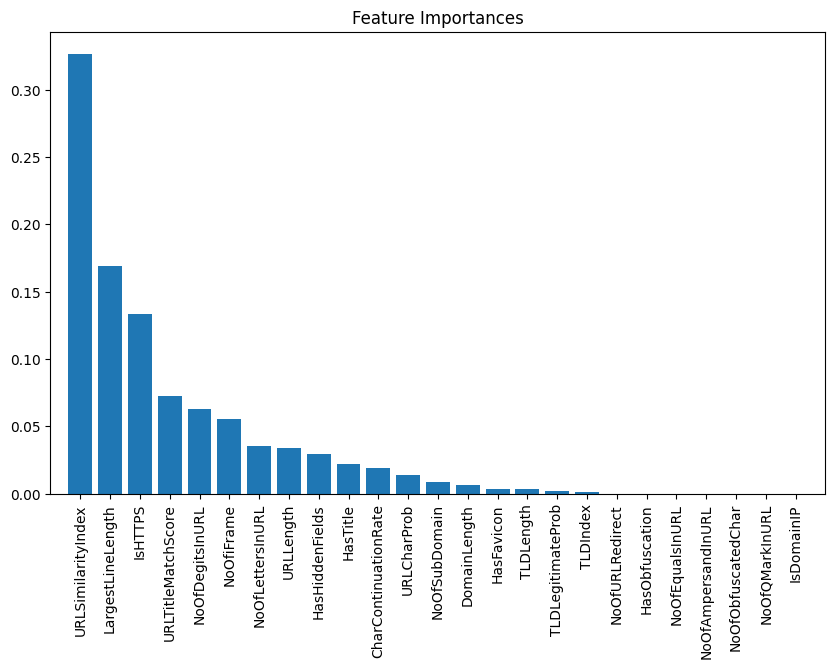

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have trained the RandomForestClassifier model 'forest'
# And X_train is your training data

# Step 1: Extract feature importances
importances = forest.feature_importances_

# Step 2: Get the indices of the features sorted by importance
indices = np.argsort(importances)[::-1]

# Step 3: Get the feature names (optional, if you have them)
# Assuming X_train is a DataFrame, otherwise use a list of feature names
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

# Step 4: Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### Split to train test (Categorical)

### Domain

In [47]:
domain_features = ['URLLength', 'DomainLength', 'IsDomainIP', 'TLDIndex', 'URLSimilarityIndex', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain', 'HasObfuscation', 'NoOfObfuscatedChar', 'NoOfLettersInURL', 'NoOfDegitsInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'IsHTTPS']
X_domain = to_train_data[domain_features]
y_domain = to_train_data[['label']]
X_domain.shape, y_domain.shape

((235795, 18), (235795, 1))

In [48]:
X_train_domain, X_test_domain, y_train_domain, y_test_domain = train_test_split(X_domain, y_domain, test_size=0.33, random_state=42)

X_train_domain.shape, X_test_domain.shape, y_train_domain.shape, y_test_domain.shape

((157982, 18), (77813, 18), (157982, 1), (77813, 1))

In [49]:
from sklearn.ensemble import RandomForestClassifier

forest_domain = RandomForestClassifier(max_depth=2, random_state=0)
forest_domain.fit(X_train_domain, y_train_domain)

f:\CodeProjects\College\Cyber 2\Project\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(max_depth=2, random_state=0)

In [50]:
# Calculate accuracy on the training set
train_accuracy_domain = forest.score(X_train_domain, y_train_domain)

# Calculate accuracy on the test set (if you have a separate test set)
test_accuracy_domain = forest.score(X_test_domain, y_test_domain)

print(f'Training Accuracy: {train_accuracy_domain}')
print(f'Test Accuracy: {test_accuracy_domain}')

Training Accuracy: 0.9969110404982846
Test Accuracy: 0.9967229126238546


### HTML Features

In [78]:
html_features = ['LargestLineLength', 'HasTitle', 'URLTitleMatchScore', 'HasFavicon', 'NoOfURLRedirect', 'NoOfiFrame', 'HasHiddenFields']
X_html = to_train_data[html_features]
y_html = to_train_data[['label']]
X_html.shape, y_html.shape

X_html.columns

Index(['LargestLineLength', 'HasTitle', 'URLTitleMatchScore', 'HasFavicon',
       'NoOfURLRedirect', 'NoOfiFrame', 'HasHiddenFields'],
      dtype='object')

In [79]:
X_train_html, X_test_html, y_train_html, y_test_html = train_test_split(X_html, y_html, test_size=0.33, random_state=42)

X_train_html.shape, X_test_html.shape, y_train_html.shape, y_test_html.shape

((157982, 7), (77813, 7), (157982, 1), (77813, 1))

In [80]:
from sklearn.ensemble import RandomForestClassifier

forest_html = RandomForestClassifier(max_depth=2, random_state=0)
forest_html.fit(X_train_html, y_train_html)

f:\CodeProjects\College\Cyber 2\Project\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(max_depth=2, random_state=0)

In [82]:
# Calculate accuracy on the training set
train_accuracy_html = forest_html.score(X_train_html, y_train_html)

# Calculate accuracy on the test set (if you have a separate test set)
test_accuracy_html = forest_html.score(X_test_html, y_test_html)

print(f'Training Accuracy: {train_accuracy_html}')
print(f'Test Accuracy: {test_accuracy_html}')

Training Accuracy: 0.904609385879404
Test Accuracy: 0.9033323480652333


## Save models

In [83]:
import pickle

with open("forest_domain.pkl", "wb") as forest_domain_file:
  pickle.dump(forest_domain, forest_domain_file)

with open("forest_html.pkl", "wb") as forest_html_file:
  pickle.dump(forest_html, forest_html_file)

In [64]:
print(forest_domain.predict(X_test_domain.head(1)))

[1]
